In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
PATH = Path("./MNIST")

In [4]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_ds = datasets.MNIST(PATH, train=True, download=True, transform=tfms)
test_ds = datasets.MNIST(PATH, train=False, download=True, transform=tfms)

In [7]:
train_dl = data.DataLoader(train_ds, batch_size=64)
test_dl = data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, latent_size)
        
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size):
        super().__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(latent_size, output_size)
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, latent_size, loss_fn, lr=1e-4, l2=0.):
        super().__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.E = Encoder(input_size, latent_size)
        self.D = Decoder(latent_size, input_size)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.loss_fn = loss_fn
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        h = self.E(x)
        self.hidden = h
        o = self.D(h)
        return o
    
    def loss(self, pred, target):
        l1_loss = torch.abs(self.hidden).mean()
        target = target.view(-1, self.input_size)
        self._loss = self.loss_fn(pred, target) # + l1_loss
        return self._loss

In [11]:
def train(epoch, model, dl):
    train_size = len(dl)
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(dl):
        model.optim.zero_grad()
        data = data.to(device)
        output = model(data)
        loss = model.loss(output, data)
        loss.backward()
        model.optim.step()
        train_loss += model._loss.item()
    print(f"Train epoch {epoch}: loss {train_loss / train_size}")

In [12]:
def plot_images(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [13]:
model = AutoEncoder(28*28, 64, F.mse_loss).to(device)

In [14]:
%%time
for epoch in range(1,101):
    model.train()
    train(epoch, model, train_dl)

Train epoch 1: loss 0.3162531255881415
Train epoch 2: loss 0.18641870778633843
Train epoch 3: loss 0.13838549640609513
Train epoch 4: loss 0.10991716789188924
Train epoch 5: loss 0.09105907673679435
Train epoch 6: loss 0.07782891881999685
Train epoch 7: loss 0.06800281424432802
Train epoch 8: loss 0.06030163105362768
Train epoch 9: loss 0.05415432184124425
Train epoch 10: loss 0.049221917696948496
Train epoch 11: loss 0.04524311817276961
Train epoch 12: loss 0.041984160067334866
Train epoch 13: loss 0.039310296846509996
Train epoch 14: loss 0.037091731582321465
Train epoch 15: loss 0.035219886604307304
Train epoch 16: loss 0.0336111976699566
Train epoch 17: loss 0.03221187464741946
Train epoch 18: loss 0.03099322593264552
Train epoch 19: loss 0.0299277015741287
Train epoch 20: loss 0.02899024678247252
Train epoch 21: loss 0.028161377497096813
Train epoch 22: loss 0.027425827533959835
Train epoch 23: loss 0.02676890300376329
Train epoch 24: loss 0.02618067102161234
Train epoch 25: loss 

In [15]:
torch.save(model.state_dict(), PATH / "ae.model")

In [16]:
def plot_images_with_noise(img, noisy_img):
    model.eval()
    output = model(img.to(device))
    output = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
    noisy_output = model(noisy_img.to(device))
    noisy_output = noisy_output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
    print("Original image")
    plot_images(img, (8,8))
    print("Image with noise")
    plot_images(noisy_img, (8,8))
    print("Decoded from original image")
    plot_images(output, (8,8))
    print("Decoded from image with noise")
    plot_images(noisy_output, (8,8))

In [17]:
img, _ = next(iter(test_dl))

## Add normal noise to image

Original image


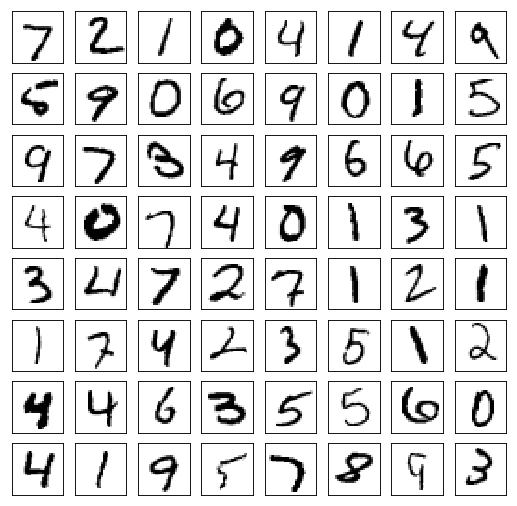

Image with noise


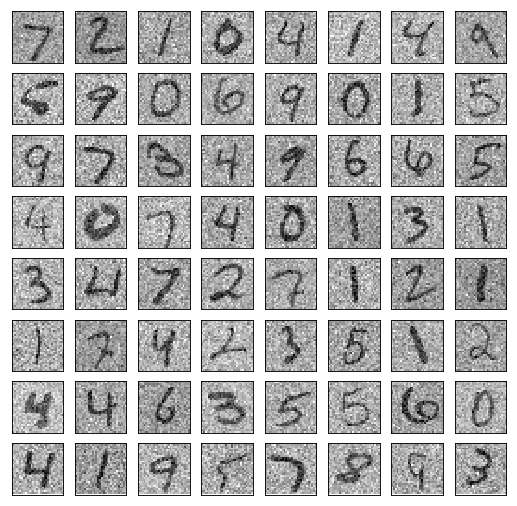

Decoded from original image


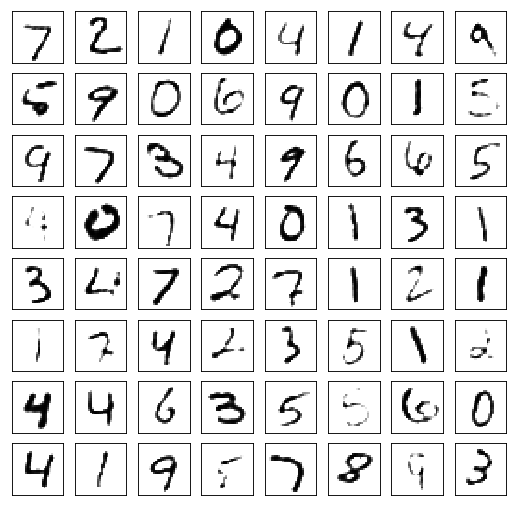

Decoded from image with noise


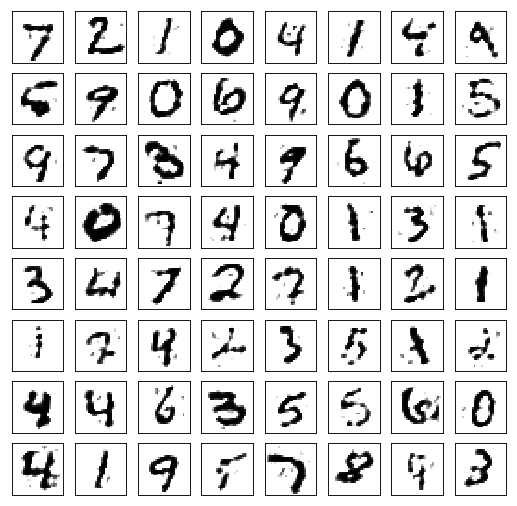

In [18]:
noise = torch.tensor(np.random.normal(0.5, 0.5, [64,1,28,28]), dtype=torch.float)
noisy_img = img + noise
plot_images_with_noise(img, noisy_img)

## Zero 50% of image

Original image


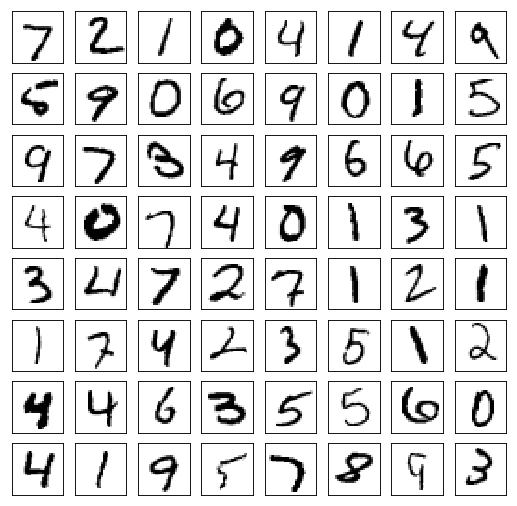

Image with noise


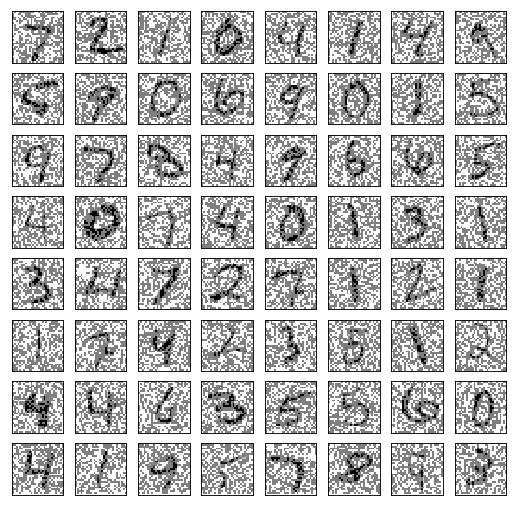

Decoded from original image


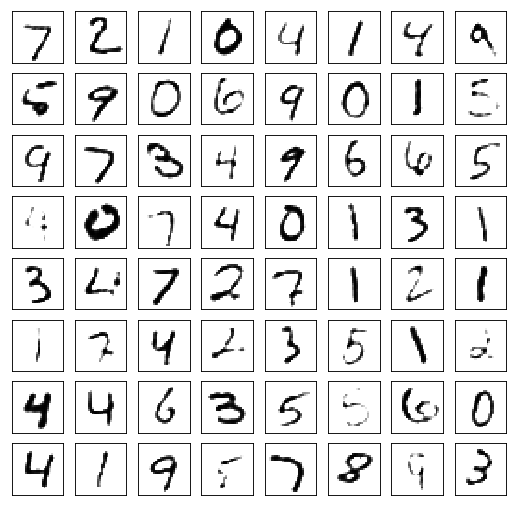

Decoded from image with noise


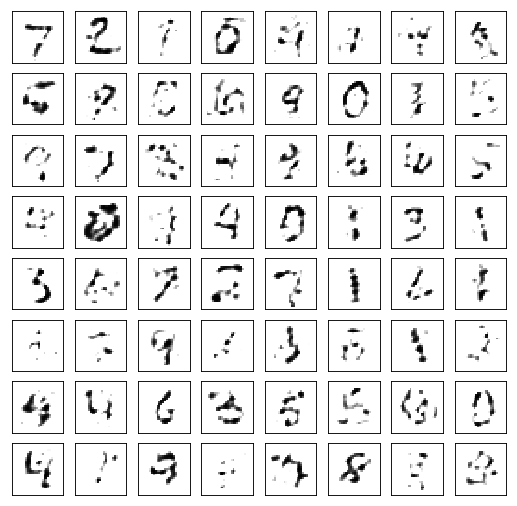

In [19]:
noise = np.random.uniform(0.0, 1.0, [64,1,28,28])
noise[noise>=0.5] = 1.0
noise[noise<0.5] = 0.0
noisy_img = img * torch.tensor(noise, dtype=torch.float)
plot_images_with_noise(img, noisy_img)

## Zero right side of image

Original image


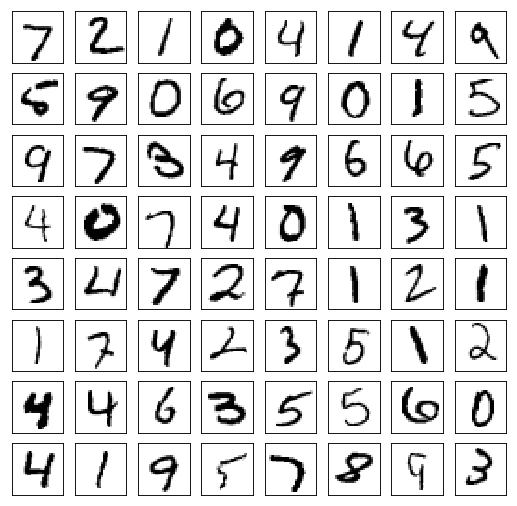

Image with noise


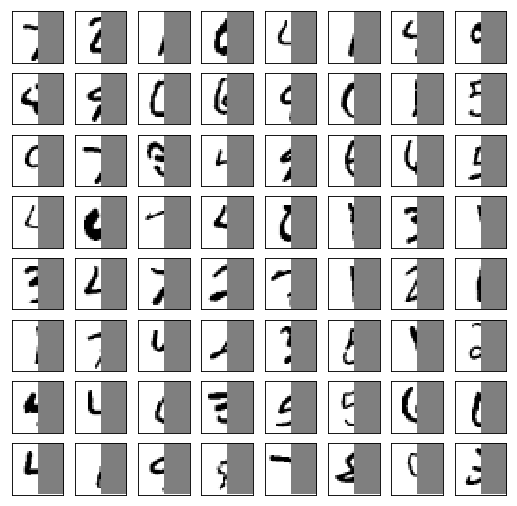

Decoded from original image


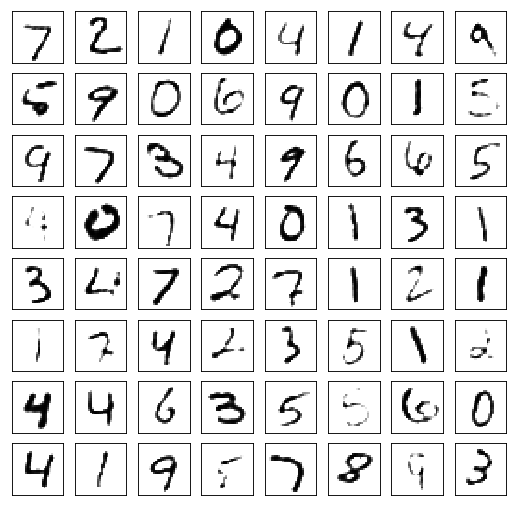

Decoded from image with noise


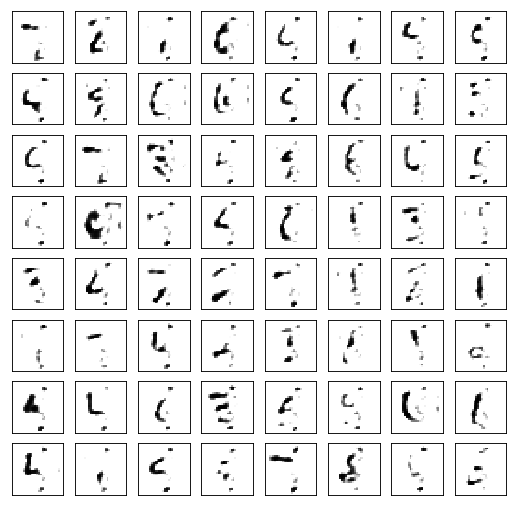

In [20]:
left = img[:,:,:,:14]
right = torch.zeros([64,1,28,14])
noisy_img = torch.cat([left,right], dim=3)
plot_images_with_noise(img, noisy_img)